SimCLR study on Cifar10 data. 

Network: ResNet18 

Batch size: 256

Optimizer: SGD

Loss: NT-Xent loss

lr:  0.3

Pre-Training data: 10000 images (1000 image per class)

Trained for 300 epochs

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
from torch.optim import lr_scheduler
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *


### Augmentaion on pre-training data

In [41]:
class Augment_train(object):
  def __init__(self,size):
    s = 0.5 # jitter strength
    size = 32
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    
    self.train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.8), 
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
  
  def __call__(self,x):
    transform = self.train_transforms

    xi = transform(x)
    xj = transform(x)
    return xi, xj

### Augmentaion on evaluation data to check pre-text task performance

In [42]:
class Augment_eval(object):
  
  def __init__(self, size):
    size = 32
    
    self.eval_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    def __call__(self,x):
      transform = self.eval_transforms
      xi = transform(x)
      xj = transform(x)

      return xi,xj
  

### Downloaing data

In [43]:
dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform= Augment_train(32))


Files already downloaded and verified


### Create a subset with less data and equal distribution of classes 


In [44]:
with open('datalabel.txt', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['current_class','label'])

def create_subset(ds):
  
  airplane_i, dog_i, deer_i, frog_i, cat_i, bird_i, horse_i, automobile_i, ship_i, truck_i = [], [], [], [], [],[],[],[],[],[]
  dog_idx, deer_idx, airplane_idx, frog_idx, cat_idx, bird_idx, automobile_idx, ship_idx, truck_idx, horse_idx = ds.class_to_idx['dog'], ds.class_to_idx['deer'],ds.class_to_idx['airplane'],ds.class_to_idx['frog'],ds.class_to_idx['cat'],ds.class_to_idx['bird'],ds.class_to_idx['automobile'],ds.class_to_idx['ship'],ds.class_to_idx['truck'],ds.class_to_idx['horse']
  label=[]
  for i in range(len(ds)):
    current_class = ds[i][1]
    if current_class == dog_idx:
      dog_i.append(i)
      label='dog'
    elif current_class == deer_idx:
      deer_i.append(i)
      label='deer'
    elif current_class == airplane_idx:
      airplane_i.append(i)
      label='airplane'
    elif current_class == frog_idx:
      frog_i.append(i)
      label='frog'
    elif current_class == cat_idx:
      cat_i.append(i)
      label='cat'
    elif current_class == bird_idx:
      bird_i.append(i)
      label='bird'
    elif current_class == automobile_idx:
      automobile_i.append(i)
      label='automobile'
    elif current_class == ship_idx:
      ship_i.append(i)
      label='ship'
    elif current_class == truck_idx:
      truck_i.append(i) 
      label='truck'
    else:
      horse_i.append(i)
      label='horse'
    with open('datalabel.txt', 'a', newline='') as csvfile:
          writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
          writer.writerow([current_class, label])

  airplane_ui = airplane_i[:int(0.2 * len(airplane_i))]
  dog_ui = dog_i[:int(0.2 * len(dog_i))]
  deer_ui = deer_i[:int(0.2 * len(deer_i))]
  frog_ui = frog_i[:int(0.2 * len(frog_i))]
  cat_ui = cat_i[:int(0.2 * len(cat_i))]
  bird_ui = bird_i[:int(0.2 * len(bird_i))]
  horse_ui = horse_i[:int(0.2 * len(horse_i))]
  automobile_ui = automobile_i[:int(0.2 * len(automobile_i))]
  ship_ui = ship_i[:int(0.2 * len(ship_i))]
  truck_ui = truck_i[:int(0.2 * len(truck_i))]

  unlabelled_dataset = Subset(ds, airplane_ui+ dog_ui+ deer_ui+ frog_ui+ cat_ui+ bird_ui+ horse_ui+ automobile_ui+ ship_ui+ truck_ui)
  
  
  return unlabelled_dataset
unlabelled_dataset = create_subset(dataset)
print(len(unlabelled_dataset))

10000


### Prepare the Train loader

In [45]:
trainloader = torch.utils.data.DataLoader(
    unlabelled_dataset, batch_size=256, shuffle=True, num_workers=8)

In [46]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

plt.figure(figsize=(16,16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


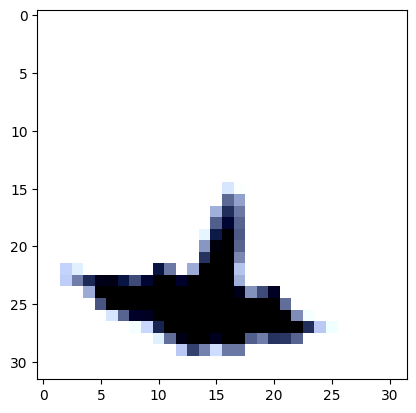

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


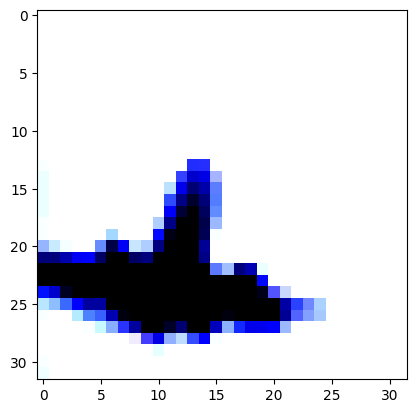

In [47]:
# visualize augmented images 

for images, labels in trainloader:
    imshow(images[0][1])
    imshow(images[1][1])
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


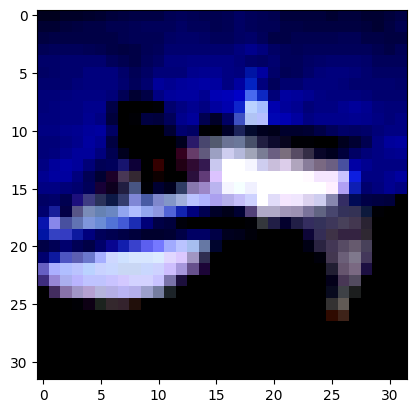

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


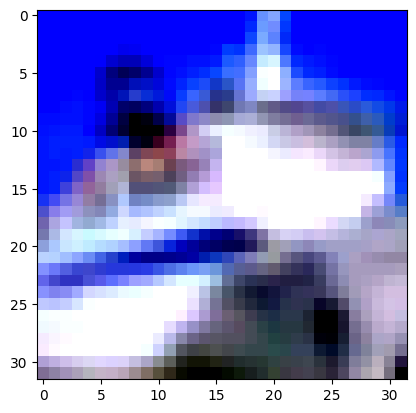

In [48]:
for images, labels in trainloader:
    imshow(images[0][1])
    imshow(images[1][1])
    print()
    break

### SimCLR  specific Loss function Cosine Similarity

In [49]:
class NTXent_L(nn.Module):
  def __init__(self,batch_size,temperature=0.5):
      super().__init__()
      self.batch_size=batch_size
      self.temperature = temperature
      
  def cosine_sim(self, output1,output2): #output1, output2 as 2 augmented versions of image;
    o_con= torch.cat([output1,output2], dim=0)
    return F.cosine_similarity(o_con.unsqueeze(1), o_con.unsqueeze(0), dim=2)
  def forward(self, z_i, z_j):

    batch_size= z_i.shape[0]

    sim_m = self.cosine_sim(z_i,z_j)

    sim_ij = torch.diag(sim_m,batch_size)
    sim_ji = torch.diag(sim_m, -batch_size)
   
    sim_con= torch.cat([sim_ij, sim_ji],dim=0)
    pos= torch.exp(sim_con/self.temperature)
    mask = (~torch.eye(batch_size *2 ,batch_size*2, dtype=bool)).float()
    neg= mask.to(device) *torch.exp(sim_m/self.temperature)
    loss = torch.sum(-torch.log(pos/torch.sum(neg, dim=1))) / (2*self.batch_size)
    
    return loss

In [50]:
criterion = NTXent_L(batch_size=256, temperature = 0.5)
criterion = criterion.to(device)

In [51]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

### SimCLR Model

In [52]:
class SimCLR_model(nn.Module):

    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.linear=nn.Linear(n_features, n_features)

        self.base_encoder.fc = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)

        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
       
        return h_i, h_j, z_i, z_j

### Base encoder = ResNet18

In [53]:
base_encoder = ResNet50()
print(base_encoder)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [54]:
projection_dim=128
n_features= base_encoder.linear.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
net= net.to(device)
#net

In [55]:
batch_size = 256
lr = 0.3
start_epoch=0
max_epoch=300
optimizer= torch.optim.SGD(net.parameters(), lr)

### Train the Pre-text task

In [56]:
net.base_encoder.linear.weight


Parameter containing:
tensor([[-0.0198, -0.0106, -0.0024,  ...,  0.0189, -0.0215,  0.0013],
        [ 0.0111,  0.0076, -0.0175,  ...,  0.0113,  0.0116,  0.0112],
        [ 0.0160, -0.0062,  0.0190,  ..., -0.0037, -0.0192,  0.0065],
        ...,
        [ 0.0063,  0.0176,  0.0206,  ...,  0.0204, -0.0155,  0.0111],
        [ 0.0063,  0.0089, -0.0186,  ..., -0.0086,  0.0186,  0.0009],
        [-0.0055,  0.0046, -0.0050,  ..., -0.0086,  0.0214, -0.0087]],
       device='cuda:0', requires_grad=True)

In [57]:
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    net.train()
    s=0
    tot_loss = 0
    total = 0
    batch_idx=0
    i=0
    for batch_idx, (images, targets) in enumerate(trainloader):
        images[0], images[1], labels = images[0].to(device),images[1].to(device), targets.to(device)
        optimizer.zero_grad()

        h_i, h_j, z_i, z_j = net(images[0], images[1])
        loss= criterion(z_i,z_j)

        loss.backward()

        optimizer.step()

        tot_loss += loss.item()
        # print('batch loss', loss.item())

    if epoch % 10 == 0:
        print("epoch=",epoch)
        print("epoch loss=",tot_loss)

    if epoch % 25 == 0:
        modelstate_save_name = 'modelstate_bs_restart_r.pt'
        path_modelstate = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{modelstate_save_name}" 
        torch.save(net.state_dict(), path_modelstate)

        parameters_end = {
            'net': net.state_dict(),
            'epoch': epoch,
            'loss': tot_loss
        }
        paramsend_save_name = 'paramsend_bs_restart_r.pt'
        path_paramsend = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{paramsend_save_name}" 
        torch.save(parameters_end, path_paramsend)

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(epoch)
      

epoch= 0
epoch loss= 233.31295031309128
epoch= 10
epoch loss= 207.9650985300541
epoch= 20
epoch loss= 201.53902457654476
epoch= 30
epoch loss= 198.08643026649952
epoch= 40
epoch loss= 195.93843565881252
epoch= 50
epoch loss= 194.5536212325096
epoch= 60
epoch loss= 192.5896695703268
epoch= 70
epoch loss= 192.57478781044483
epoch= 80
epoch loss= 190.61799731850624
epoch= 90
epoch loss= 190.42702248692513
epoch= 100
epoch loss= 189.4749294668436
epoch= 110
epoch loss= 188.95396001636982
epoch= 120
epoch loss= 188.43114568293095
epoch= 130
epoch loss= 191.1613228470087
epoch= 140
epoch loss= 187.91238513588905
epoch= 150
epoch loss= 187.97919577360153
epoch= 160
epoch loss= 187.26442359387875
epoch= 170
epoch loss= 186.78734776377678
epoch= 180
epoch loss= 186.5803474187851
epoch= 190
epoch loss= 186.45508091151714
epoch= 200
epoch loss= 187.25713562965393
epoch= 210
epoch loss= 186.0587771013379
epoch= 220
epoch loss= 185.7241676747799
epoch= 230
epoch loss= 185.8436635285616
epoch= 240
e